In [5]:
#Import Modules
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import tensorflow as tf
import keras
import keras.layers as layers
from Sum import Sum
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy.lib.recfunctions import structured_to_unstructured
from tensorflow.keras import callbacks
import time
from tensorflow.keras.constraints import max_norm
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, r2_score, balanced_accuracy_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy.stats import gaussian_kde, pearsonr
import seaborn as sns
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [6]:
#Open the root file
tree = uproot.open("training_data.root:tree;12")
jetfeatures = ["jet_pt", "jet_eta", "jet_phi", "jet_M", "jet_flav"]
trackfeatures = ["trk_pt", "trk_eta", "trk_phi", "trk_d0", "trk_z0", "trk_charge", "trk_pterr", "trk_phierr", "trk_d0err", "trk_z0err"]
trackpos = ["trk_prod_x", "trk_prod_y", "trk_prod_z", "trk_dec_x", "trk_dec_y", "trk_dec_z"]
hadfeatures = ["hadron_pdgid", "hadron_decx", "hadron_decy", "hadron_decz"]
vertfeatures = ["true_vtx_x", "true_vtx_y", "true_vtx_z", "true_vtx_ntrks"]

In [7]:
# Read in the requested branches from the file
MAXEVENTS = 99999999999999999
features = tree.arrays(jetfeatures + trackfeatures + hadfeatures + vertfeatures + trackpos, entry_stop=MAXEVENTS)

In [8]:
MASKVAL = -999
MAXTRACKS = 15

In [9]:
#Find where angular distance is small
def matchTracks(jets, trks):
  jeteta = jets["jet_eta"] 
  jetphi = jets["jet_phi"]

  trketas = trks["trk_eta"]
  trkphis = trks["trk_phi"]

  detas = jeteta - trketas
  dphis = np.abs(jetphi - trkphis)

  # deal with delta phis being annoying
  ak.where(dphis > np.pi, dphis - np.pi, dphis)

  return np.sqrt(dphis**2 + detas**2) < 0.4

In [10]:
#Converting from polar to cartesian

#Used for jets
def ptetaphi2pxpypz(ptetaphi):
  pts = ptetaphi[:,0:1]
  etas = ptetaphi[:,1:2]
  phis = ptetaphi[:,2:3]

  pxs = pts * np.cos(phis)
  pys = pts * np.sin(phis)
  pzs = pts * np.sinh(etas)

  isinf = np.isinf(pzs)

  if np.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return np.concatenate([pxs, pys, pzs], axis=1)

#Used for tracks
def ptetaphi2pxpypz2(ptetaphi):
  pts = ptetaphi[:,:,0:1]
  etas = ptetaphi[:,:,1:2]
  phis = ptetaphi[:,:,2:3]

  mask = pts == -999
  #Looking in array and testing a condition - if finds mask, replaces mask with pt value
  pxs = np.where(mask, pts, pts * np.cos(phis)) # Apply transformation only to actual pT
  pys = np.where(mask, pts, pts * np.sin(phis))
  pzs = np.where(mask, pts, pts * np.sinh(etas))

  isinf = np.isinf(pzs)

  if np.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return np.concatenate([pxs, pys, pzs], axis=2)

In [11]:
# Pads inputs with nans up to the given maxsize
def pad(xs, maxsize):
  #Find 'none' values in array and replace with MASKVAL (= fill_none)
  ys = \
    ak.fill_none \
  ( ak.pad_none(xs, maxsize, axis=1, clip=True) #Adding 'none' values to make sure it is correct size
  , MASKVAL
  )[:,:maxsize]

  return ak.to_regular(ys, axis=1)


def flatten1(xs, maxsize=-1):
  ys = {}
  for field in xs.fields:
    zs = xs[field]
    if maxsize > 0:
      zs = pad(zs, maxsize)
    ys[field] = zs

  return ak.zip(ys)

In [12]:
def binneddensitysub(xs, binning, ax, label=None, xlabel=None, ylabel="binned probability density", color = 'blue'):
  #fig = figure.Figure(figsize=(8, 8))
  #plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  ax.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    , ecolor = color
    , marker = 'None'
    )

  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  #return fig
def fixedbinning(xmin, xmax, nbins):
  return np.mgrid[xmin:xmax:nbins*1j]

# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = np.histogram(xs, bins=binning)[0]

  yerrs = np.sqrt(ys)

  if normalized:
    s = np.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs

In [13]:
# Select the events of interest and load into awkward arrays
goodjets = \
  np.logical_and \
    ( np.abs(features["jet_eta"]) < 2.5
    , features["jet_pt"] > 25
    )

events = features[goodjets]
events = events[:100000]

jets_ak = events[jetfeatures]
tracks_ak = events[trackfeatures]
trackpos_ak = events[trackpos]
vertices_ak = events[vertfeatures]
hadrons_ak = events[hadfeatures]

In [14]:
matchedtracks = tracks_ak[matchTracks(jets_ak, tracks_ak)] 
matchedtracks = flatten1(matchedtracks, MAXTRACKS)
matchedtrackpos = trackpos_ak[matchTracks(jets_ak, tracks_ak)]
matchedtrackpos = flatten1(matchedtrackpos, MAXTRACKS)

In [15]:
#Convert to pandas dataframes
jets_df = ak.to_pandas(jets_ak)
tracks_df = ak.to_pandas(matchedtracks)
tracks_df = tracks_df.mask(tracks_df == -999)
trackpos_df = ak.to_pandas(matchedtrackpos)
trackpos_df = trackpos_df.mask(trackpos_df == -999)
vertices_df = ak.to_pandas(vertices_ak[:,0]) #The first vertex
#hadrons_df = ak.to_pandas(hadrons_ak[:,0]) #Selecting the first hadron

In [16]:
jets_df.head().apply(lambda x: x.round(2))

,jet_pt,jet_eta,jet_phi,jet_M,jet_flav
entry,,,,,
0,136.059998,-0.30,-0.25,23.790001,0.0
1,92.489998,-0.49,1.66,15.410000,0.0
2,63.259998,-0.63,0.93,7.210000,4.0
3,46.790001,-0.00,-0.99,4.650000,0.0
4,78.489998,1.16,-2.99,6.750000,4.0


In [17]:
jets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   jet_pt    100000 non-null  float32
 1   jet_eta   100000 non-null  float32
 2   jet_phi   100000 non-null  float32
 3   jet_M     100000 non-null  float32
 4   jet_flav  100000 non-null  float32
dtypes: float32(5)
memory usage: 1.9 MB


In [18]:
jets_df[jets_df.isnull().any(axis=1)]

,jet_pt,jet_eta,jet_phi,jet_M,jet_flav
entry,,,,,


In [19]:
jets_df.describe(include='all').apply(lambda x: x.round(2))

,jet_pt,jet_eta,jet_phi,jet_M,jet_flav
count,100000.00,100000.00,100000.00,100000.00,100000.00
mean,59.24,-0.00,0.00,7.17,2.33
std,28.52,1.21,1.81,3.80,2.36
min,25.00,-2.50,-3.14,-14.34,0.00
25%,36.69,-0.93,-1.57,4.59,0.00
50%,52.06,-0.00,-0.01,6.42,4.00
75%,74.68,0.93,1.58,9.01,5.00
max,199.77,2.50,3.14,47.10,5.00


In [20]:
tracks_df.head().apply(lambda x: x.round(2))

trk_pt  trk_eta  trk_phi  trk_d0  trk_z0  trk_charge  \
entry subentry                                                         
0     0           7.97    -0.03    -0.23    0.00    0.01        -1.0   
      1           8.49    -0.23    -0.21   -0.03    0.08         1.0   
      2           4.55    -0.54    -0.42    0.02    0.02         1.0   
      3           3.67    -0.45    -0.40   -0.00    0.13         1.0   
      4           1.27    -0.64    -0.12   -0.04    0.20         1.0   

                trk_pterr  trk_phierr  trk_d0err  trk_z0err  
entry subentry                                               
0     0              0.06         0.0       0.03       0.06  
      1              0.08         0.0       0.03       0.05  
      2              0.05         0.0       0.06       0.08  
      3              0.04         0.0       0.07       0.08  
      4              0.01         0.0       0.09       0.12

In [21]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1500000 entries, (0, 0) to (99999, 14)
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trk_pt      694623 non-null  float64
 1   trk_eta     694623 non-null  float64
 2   trk_phi     694623 non-null  float64
 3   trk_d0      694623 non-null  float64
 4   trk_z0      694623 non-null  float64
 5   trk_charge  694623 non-null  float64
 6   trk_pterr   694623 non-null  float64
 7   trk_phierr  694623 non-null  float64
 8   trk_d0err   694623 non-null  float64
 9   trk_z0err   694623 non-null  float64
dtypes: float64(10)
memory usage: 124.4 MB


In [22]:
tracks_df[tracks_df.isnull().any(axis=1)]

trk_pt  trk_eta  trk_phi  trk_d0  trk_z0  trk_charge  \
entry subentry                                                         
0     14           NaN      NaN      NaN     NaN     NaN         NaN   
1     7            NaN      NaN      NaN     NaN     NaN         NaN   
      8            NaN      NaN      NaN     NaN     NaN         NaN   
      9            NaN      NaN      NaN     NaN     NaN         NaN   
      10           NaN      NaN      NaN     NaN     NaN         NaN   
...                ...      ...      ...     ...     ...         ...   
99999 10           NaN      NaN      NaN     NaN     NaN         NaN   
      11           NaN      NaN      NaN     NaN     NaN         NaN   
      12           NaN      NaN      NaN     NaN     NaN         NaN   
      13           NaN      NaN      NaN     NaN     NaN         NaN   
      14           NaN      NaN      NaN     NaN     NaN         NaN   

                trk_pterr  trk_phierr  trk_d0err  trk_z0err  
entry subentry                                               
0     14              NaN         NaN        NaN        NaN  
1     7               NaN         NaN        NaN        NaN  
      8               NaN         NaN        NaN        NaN  
      9               NaN         NaN        NaN        NaN  
      10              NaN         NaN        NaN        NaN  
...                   ...         ...        ...        ...  
99999 10              NaN         NaN        NaN        NaN  
      11              NaN         NaN        NaN        NaN  
      12              NaN         NaN        NaN        NaN  
      13              NaN         NaN        NaN        NaN  
      14              NaN         NaN        NaN        NaN  

[805377 rows x 10 columns]

While this could be cause for concern, as every row is filled with NaN's, this implies that each is simply the padded values we introducted to make the sub-arrays uniform

In [23]:
tracks_df.describe().apply(lambda x: x.round(2))

,trk_pt,trk_eta,trk_phi,trk_d0,trk_z0,trk_charge,trk_pterr,trk_phierr,trk_d0err,trk_z0err
count,694623.00,694623.00,694623.00,694623.00,694623.00,694623.0,694623.00,694623.00,694623.00,694623.00
mean,4.88,-0.00,0.00,0.00,0.00,-0.0,0.08,0.00,0.09,0.18
std,6.62,1.16,1.78,13.59,10.75,1.0,0.16,0.00,0.05,0.19
min,0.12,-2.58,-3.14,-897.60,-973.10,-1.0,0.00,0.00,0.01,0.03
25%,1.27,-0.88,-1.54,-0.07,-0.11,-1.0,0.02,0.00,0.06,0.09
50%,2.66,-0.00,-0.00,-0.00,-0.00,-1.0,0.04,0.00,0.08,0.11
75%,5.77,0.88,1.55,0.07,0.11,1.0,0.08,0.00,0.11,0.19
max,169.91,2.57,3.14,845.37,1368.63,1.0,21.63,0.01,0.25,1.40


In [24]:
trackpos_df.head().apply(lambda x: x.round(2))

trk_prod_x  trk_prod_y  trk_prod_z  trk_dec_x  trk_dec_y  \
entry subentry                                                             
0     0                0.0         0.0         0.0  616691.81 -146778.67   
      1                0.0         0.0         0.0  177816.28  -37560.65   
      2                0.0         0.0         0.0  568715.75 -256917.48   
      3                0.0         0.0         0.0   25761.20  -10958.81   
      4                0.0         0.0         0.0  158971.83  -19299.25   

                trk_dec_z  
entry subentry             
0     0         -16955.19  
      1         -42061.11  
      2        -355812.94  
      3         -13116.81  
      4        -109609.50

In [25]:
trackpos_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1500000 entries, (0, 0) to (99999, 14)
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trk_prod_x  694623 non-null  float64
 1   trk_prod_y  694623 non-null  float64
 2   trk_prod_z  694623 non-null  float64
 3   trk_dec_x   694623 non-null  float64
 4   trk_dec_y   694623 non-null  float64
 5   trk_dec_z   694623 non-null  float64
dtypes: float64(6)
memory usage: 78.6 MB


In [26]:
tracks_df[tracks_df.isnull().any(axis=1)]

trk_pt  trk_eta  trk_phi  trk_d0  trk_z0  trk_charge  \
entry subentry                                                         
0     14           NaN      NaN      NaN     NaN     NaN         NaN   
1     7            NaN      NaN      NaN     NaN     NaN         NaN   
      8            NaN      NaN      NaN     NaN     NaN         NaN   
      9            NaN      NaN      NaN     NaN     NaN         NaN   
      10           NaN      NaN      NaN     NaN     NaN         NaN   
...                ...      ...      ...     ...     ...         ...   
99999 10           NaN      NaN      NaN     NaN     NaN         NaN   
      11           NaN      NaN      NaN     NaN     NaN         NaN   
      12           NaN      NaN      NaN     NaN     NaN         NaN   
      13           NaN      NaN      NaN     NaN     NaN         NaN   
      14           NaN      NaN      NaN     NaN     NaN         NaN   

                trk_pterr  trk_phierr  trk_d0err  trk_z0err  
entry subentry                                               
0     14              NaN         NaN        NaN        NaN  
1     7               NaN         NaN        NaN        NaN  
      8               NaN         NaN        NaN        NaN  
      9               NaN         NaN        NaN        NaN  
      10              NaN         NaN        NaN        NaN  
...                   ...         ...        ...        ...  
99999 10              NaN         NaN        NaN        NaN  
      11              NaN         NaN        NaN        NaN  
      12              NaN         NaN        NaN        NaN  
      13              NaN         NaN        NaN        NaN  
      14              NaN         NaN        NaN        NaN  

[805377 rows x 10 columns]

In [27]:
trackpos_df.describe().apply(lambda x: x.round(2))

,trk_prod_x,trk_prod_y,trk_prod_z,trk_dec_x,trk_dec_y,trk_dec_z
count,694623.00,694623.00,694623.00,6.946230e+05,6.946230e+05,6.946230e+05
mean,0.41,0.01,0.08,3.956193e+04,2.457020e+03,2.436626e+04
std,64.04,65.22,152.52,1.468619e+07,1.461845e+07,3.783881e+07
min,-1125.02,-1130.96,-3505.41,-2.387512e+09,-1.895499e+09,-6.709077e+09
25%,-0.00,-0.00,-0.00,-2.986259e+04,-3.280927e+04,-5.203982e+04
50%,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.00,0.00,0.00,3.311410e+04,3.256521e+04,5.146880e+04
max,1142.37,1140.50,3496.23,2.411816e+09,3.426391e+09,5.658901e+09


In [28]:
vertices_df.head().apply(lambda x: x.round(2))

,true_vtx_x,true_vtx_y,true_vtx_z,true_vtx_ntrks
entry,,,,
0,0.0,0.0,0.0,13
1,0.0,0.0,-0.0,7
2,0.0,0.0,-0.0,10
3,0.0,0.0,0.0,3
4,0.0,0.0,0.0,8


In [29]:
vertices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   true_vtx_x      100000 non-null  float32
 1   true_vtx_y      100000 non-null  float32
 2   true_vtx_z      100000 non-null  float32
 3   true_vtx_ntrks  100000 non-null  int32  
dtypes: float32(3), int32(1)
memory usage: 1.5 MB


In [30]:
vertices_df[vertices_df.isnull().any(axis=1)]

,true_vtx_x,true_vtx_y,true_vtx_z,true_vtx_ntrks
entry,,,,


In [31]:
vertices_df.describe().apply(lambda x: x.round(2))

,true_vtx_x,true_vtx_y,true_vtx_z,true_vtx_ntrks
count,100000.00,100000.00,100000.00,100000.00
mean,-0.03,0.02,0.08,4.92
std,12.04,12.02,34.62,2.77
min,-833.96,-939.31,-2234.48,1.00
25%,-0.00,-0.00,-0.00,3.00
50%,0.00,0.00,0.00,5.00
75%,0.00,0.00,0.00,7.00
max,1084.21,912.40,2312.25,15.00


In [32]:
hadrons_df.head()

NameError: name 'hadrons_df' is not defined

In [ ]:
#hadrons_df.info().apply(lambda x: x.round(2))

In [ ]:
hadrons_df[hadrons_df.isnull().any(axis=1)]

In [ ]:
hadrons_df.describe().apply(lambda x: x.round(2))

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


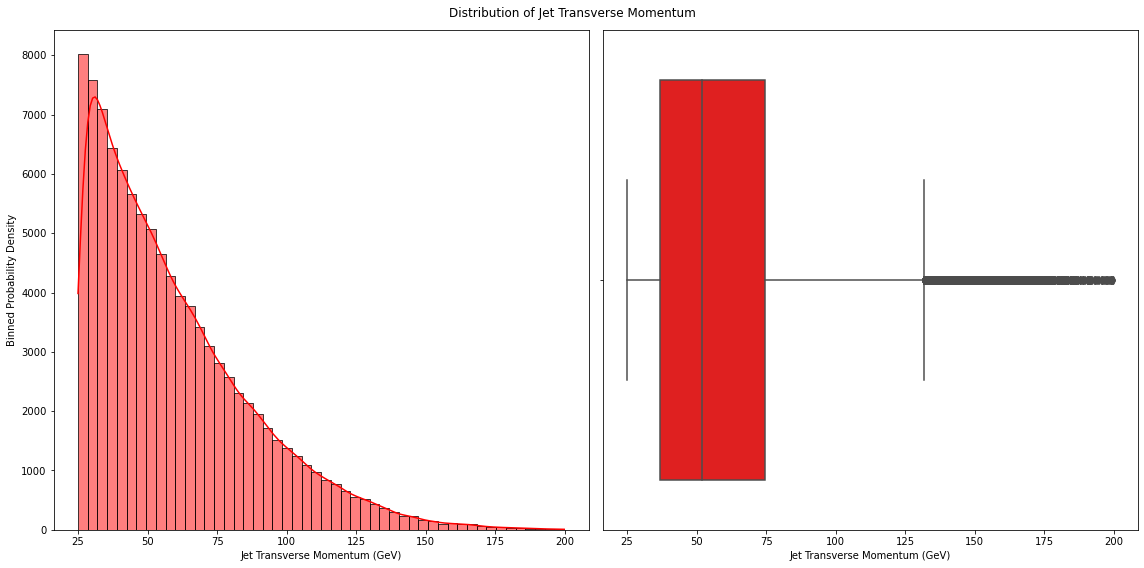

In [74]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(jets_df["jet_pt"], color = 'red', ax=ax[0], kde = True, bins = 50)
#binneddensitysub(jets_df["jet_pt"], binning = fixedbinning(0,200,100), ax = ax[0], xlabel = "Jet Transverse Momentum", color = 'red')
ax[0].errorbar()
sns.boxplot(jets_df["jet_pt"], ax = ax[1], color = 'red')
ax[0].set(xlabel = "Jet Transverse Momentum (GeV)", ylabel = "Binned Probability Density")
ax[1].set(xlabel = "Jet Transverse Momentum (GeV)")
plt.suptitle("Distribution of Jet Transverse Momentum")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


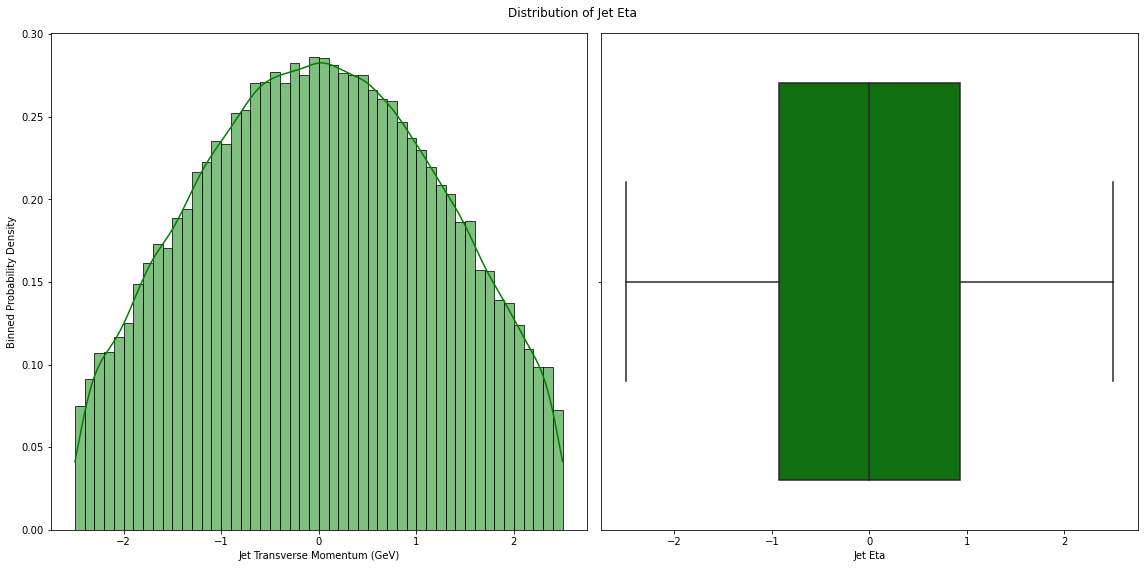

In [73]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(jets_df["jet_eta"], ax = ax[0], stat = "density", bins = 50, color = 'green', kde=True)
#binneddensitysub(jets_df["jet_eta"], binning = fixedbinning(-3,3,100), ax = ax[0], xlabel = "Jet Transverse Momentum", color = 'green')
sns.boxplot(jets_df["jet_eta"], ax = ax[1], color = 'green')
ax[0].set(xlabel = "Jet Transverse Momentum (GeV)", ylabel = "Binned Probability Density")
ax[1].set(xlabel = "Jet Eta")
plt.suptitle("Distribution of Jet Eta")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


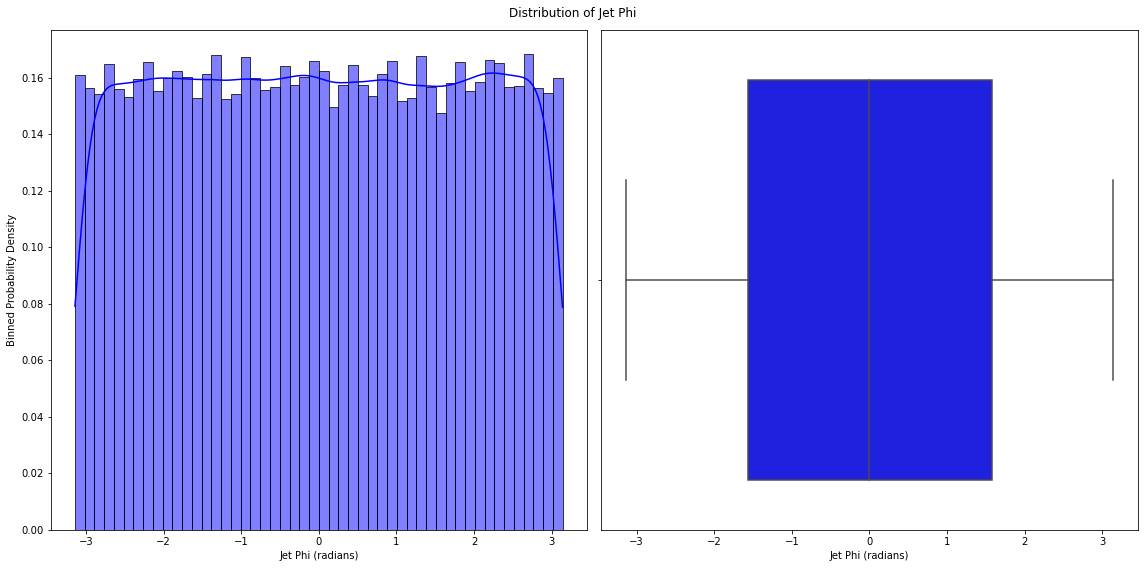

In [67]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(jets_df["jet_phi"], ax = ax[0], stat = "density", bins = 50, color = 'blue', kde = True)
#binneddensitysub(jets_df["jet_phi"], binning = fixedbinning(-4,4,100), ax = ax[0], xlabel = "Jet Phi (rad)", color = 'blue')
sns.boxplot(jets_df["jet_phi"], ax = ax[1], color = 'blue')
ax[0].set(xlabel = "Jet Phi (radians)", ylabel = "Binned Probability Density")
ax[1].set(xlabel = "Jet Phi (radians)")
plt.suptitle("Distribution of Jet Phi")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


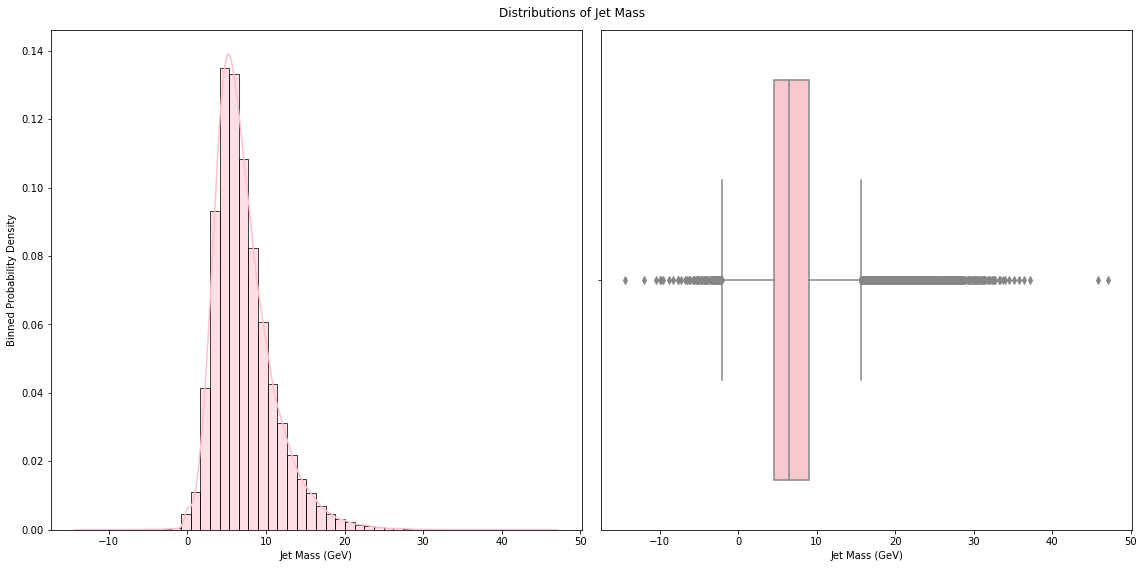

In [72]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(jets_df["jet_M"], ax = ax[0], stat = "density", bins = 50, color = 'pink', kde = True)
#binneddensitysub(jets_df["jet_M"], binning = fixedbinning(0,50,100), ax = ax[0], xlabel = "Jet Mass (GeV)", color = 'pink')
sns.boxplot(jets_df["jet_M"], ax = ax[1], color = 'pink')
ax[0].set(xlabel = "Jet Mass (GeV)", ylabel = "Binned Probability Density")
ax[1].set(xlabel = "Jet Mass (GeV)")
plt.suptitle("Distributions of Jet Mass")
plt.tight_layout()
plt.show()

Negative Masses? That is unphysical....

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


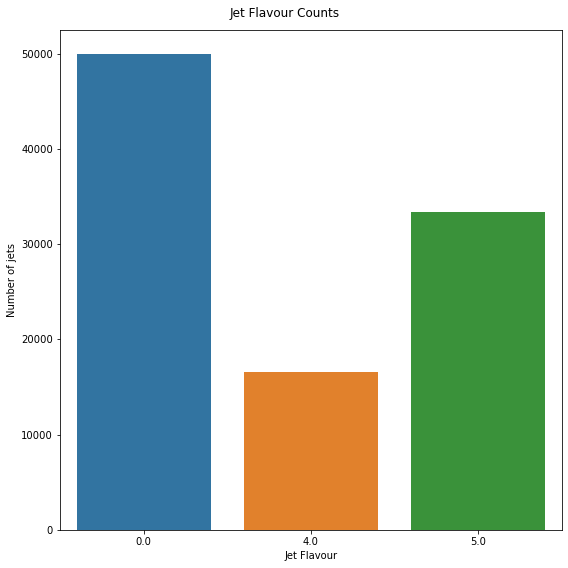

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
#sns.histplot(jets_df["jet_pt"], ax = ax[0], stat = "density", bins = 50)
#binneddensitysub(tracks_df["jet_flav"], binning = fixedbinning(0,25,100), ax = ax[0], color = 'orange')
sns.countplot(jets_df["jet_flav"])
plt.xlabel("Jet Flavour")
plt.ylabel("Number of jets")
plt.suptitle("Jet Flavour Counts")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


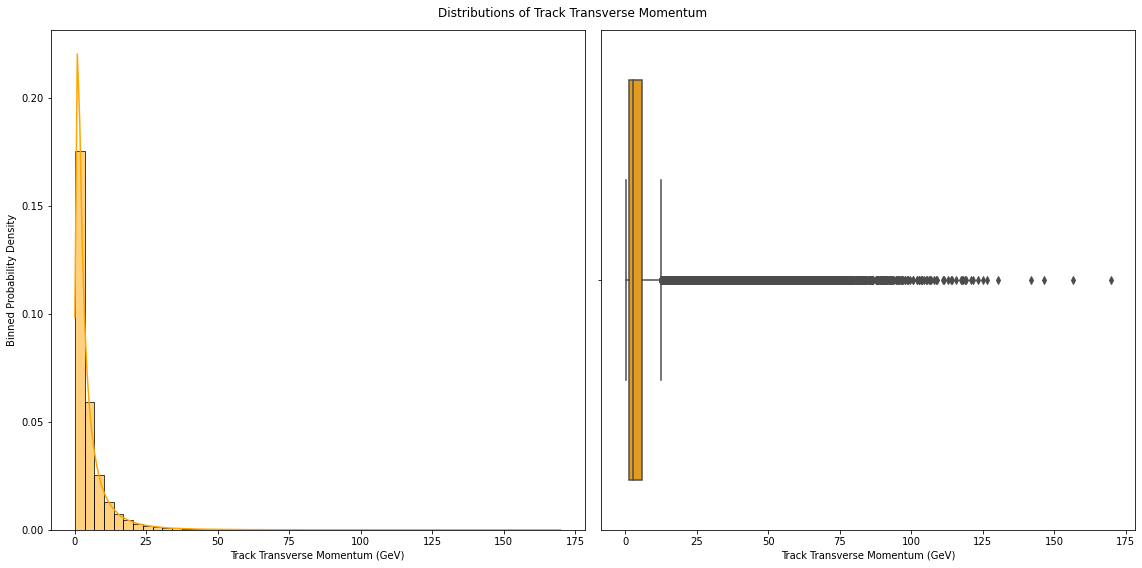

In [71]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(tracks_df["trk_pt"], ax = ax[0], stat = "density", bins = 50, kde = True, color = 'orange')
#binneddensitysub(tracks_df["trk_pt"], binning = fixedbinning(0,25,100), ax = ax[0], color = 'orange')
sns.boxplot(tracks_df["trk_pt"], ax = ax[1], color = 'orange')
ax[0].set(xlabel = "Track Transverse Momentum (GeV)", ylabel = "Binned Probability Density")
ax[1].set(xlabel = "Track Transverse Momentum (GeV)")
plt.suptitle("Distributions of Track Transverse Momentum")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


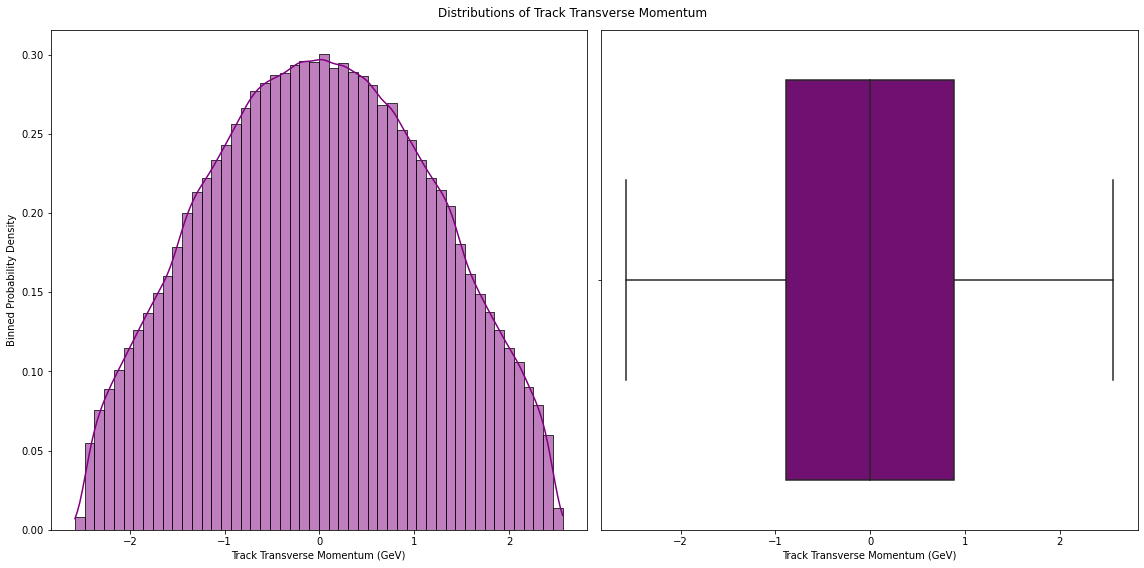

In [70]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(tracks_df["trk_eta"], ax = ax[0], stat = "density", bins = 50, kde = True, color = 'purple')
#binneddensitysub(tracks_df["trk_eta"], binning = fixedbinning(-5,5,100), ax = ax[0], color = 'purple')
sns.boxplot(tracks_df["trk_eta"], ax = ax[1], color = 'purple')
ax[0].set(xlabel = "Track Transverse Momentum (GeV)", ylabel = "Binned Probability Density")
ax[1].set(xlabel = "Track Transverse Momentum (GeV)")
plt.suptitle("Distributions of Track Transverse Momentum")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


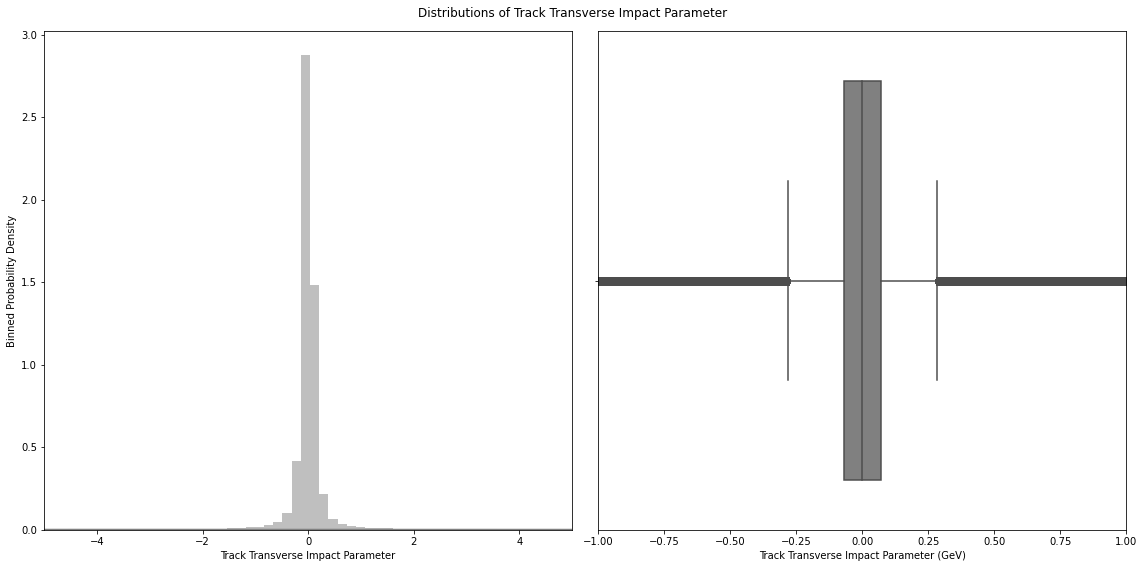

In [94]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(tracks_df["trk_d0"], ax = ax[0], stat = "density", bins = 10000, kde = True, color = 'gray')
#binneddensitysub(tracks_df["trk_d0"], binning = fixedbinning(-1,1,100), ax = ax[0], color = 'gray')
sns.boxplot(tracks_df["trk_d0"], ax = ax[1], color = 'gray')b
ax[0].set(xlabel = "Track Transverse Impact Parameter", ylabel = "Binned Probability Density")
ax[0].set_xlim(-5,5)
ax[1].set_xlim(-1,1)
ax[1].set(xlabel = "Track Transverse Impact Parameter (GeV)")
plt.suptitle("Distributions of Track Transverse Impact Parameter")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


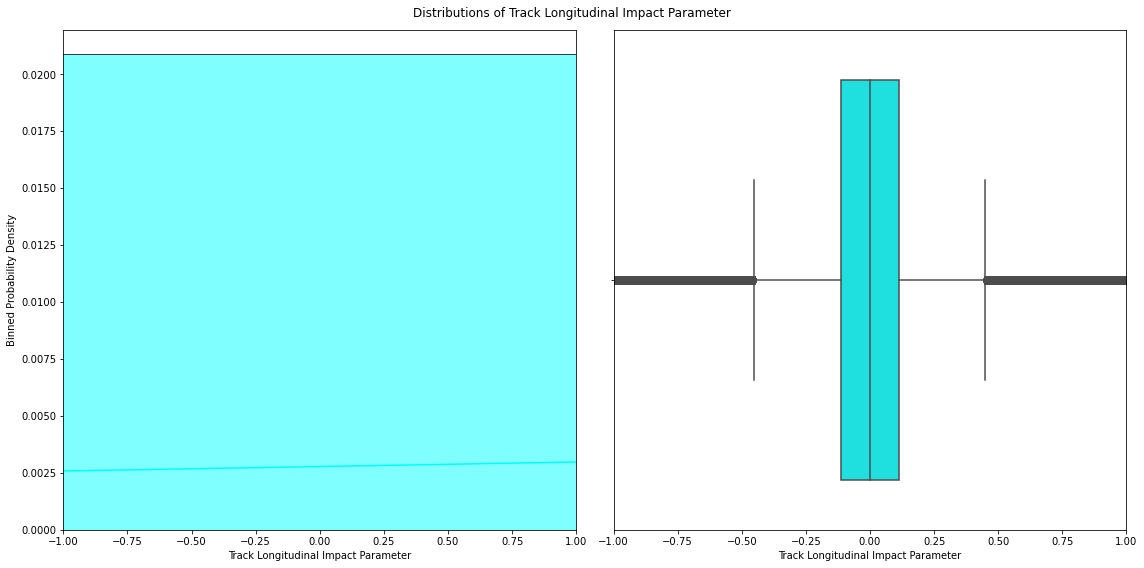

In [87]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(tracks_df["trk_z0"], ax = ax[0], stat = "density", bins = 50, color = 'cyan', kde = True)
#binneddensitysub(tracks_df["trk_z0"], binning = fixedbinning(-1,1,100), ax = ax[0], color = 'cyan')
sns.boxplot(tracks_df["trk_z0"], ax = ax[1], color = 'cyan')
ax[0].set(xlabel = "Track Longitudinal Impact Parameter", ylabel = "Binned Probability Density")
ax[0].set_xlim(-1,1)
ax[1].set_xlim(-1,1)
ax[1].set(xlabel = "Track Longitudinal Impact Parameter")
plt.suptitle("Distributions of Track Longitudinal Impact Parameter")
plt.tight_layout()
plt.show()

d:\Idc\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


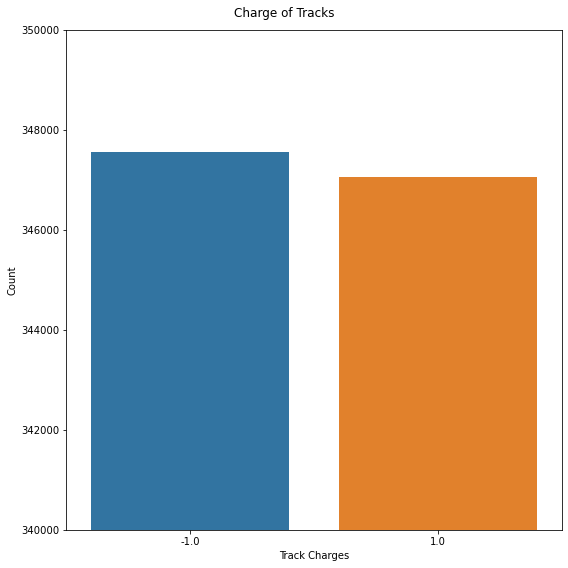

In [42]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
#sns.histplot(jets_df["jet_pt"], ax = ax[0], stat = "density", bins = 100)
#binneddensitysub(tracks_df["jet_flav"], binning = fixedbinning(0,25,100), ax = ax[0], color = 'orange')
sns.countplot(tracks_df["trk_charge"])
plt.xlabel("Track Charges")
plt.ylabel("Count")
plt.suptitle("Charge of Tracks")
plt.tight_layout()
plt.axis(ymin = 340000, ymax = 350000)
plt.show()

While the conservation of charge suggests that something is wrong here, the total sum should be greater than zero, as the dataset is from protons (+1 charge), it is likely that this is okay. Noticing where the y axis begins, there is only a slight difference, so is probably from where some tracks have been filtered out from not having been matched to the jet.

In [43]:
print(tracks_df.columns.to_list())

['trk_pt', 'trk_eta', 'trk_phi', 'trk_d0', 'trk_z0', 'trk_charge', 'trk_pterr', 'trk_phierr', 'trk_d0err', 'trk_z0err']
